# Hinge stiffness identification on 4x4 rotating square samples


## Imports

In [1]:
import jax.numpy as jnp
from problems.hinge_characterization import ForwardProblem, OptimizationProblem
from difflexmm.utils import load_data, save_data
from pathlib import Path
from typing import Dict

from jax.config import config
config.update("jax_enable_x64", True)  # enable float64 type
# config.update("jax_log_compiles", 1)

import matplotlib.pyplot as plt
plt.style.use(["science", "grid"])
%matplotlib widget


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Plotting functions

In [23]:
def plot_force_displacement_exp(exp_data: Dict[str, jnp.ndarray], figsize=(6, 3), **plot_kwargs):
    ncols = len(exp_data.keys())
    fig, axes = plt.subplots(
        ncols=ncols, figsize=figsize, constrained_layout=True)

    for (key, (u, f, std)), ax in zip(exp_data.items(), axes):
        ax.plot(u, f, label=key, **plot_kwargs)
        ax.fill_between(u, f-std, f+std, alpha=0.5, **plot_kwargs)
        ax.set(xlabel="Displacement [mm]", ylabel="Force [N]", title=f"{key} (exp)")

    return fig, axes

def plot_force_displacement_sim(sim_data: Dict[str, jnp.ndarray], figsize=(6, 3), **plot_kwargs):
    ncols = len(sim_data.keys())
    fig, axes = plt.subplots(
        ncols=ncols, figsize=figsize, constrained_layout=True)

    for (key, (u, f)), ax in zip(sim_data.items(), axes):
        ax.plot(u, f, label=key, **plot_kwargs)
        ax.set(xlabel="Displacement [mm]", ylabel="Force [N]", title=f"{key} (sim)")

    return fig, axes

def plot_force_displacement_fitting(exp_data: Dict[str, jnp.ndarray], sim_data: Dict[str, jnp.ndarray], figsize=(6, 3), **plot_kwargs):
    fig, axes = plot_force_displacement_exp(
        exp_data, figsize=figsize, **plot_kwargs)
    # Add simulated response
    for (key, (u, f)), ax in zip(sim_data.items(), axes):
        ax.plot(u, f, label=f"{key} (sim)", **plot_kwargs)
        ax.set_title(f"{key}")

    # Add legend with just two lines one for exp and one for sim overwriting the labels as exp and sim
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend([handles[0], handles[-1]], ["exp", "sim"], loc="upper left")

    return fig, axes


## Paths

In [3]:
# Where to load/save the experimental/optimization data
data_folder = Path("../../data/hinge_characterization_3dp_pla_shims")
# Where to save the plots
out_folder = Path("../../out/hinge_characterization_3dp_pla_shims")

## Fitting

In [4]:
n1_cells = 2
n2_cells = 3  # Top and bottom rows are clamped
spacing = 15.0  # mm
hinge_length = 0.15*spacing
angle = -20.0 * jnp.pi/180

k_stretch = 120.  # N/mm
k_shear = 1.18  # N/mm
k_rot = 1.5  # N/mm
density = 1.0  # Fake inertia for quasi-static analysis
damping = 0.015

test_labels = ["tension", "compression", "shear"]
amplitudes = [1.05, 3.75, 3.75]
force_multipliers = [1., -1., 1.]
problems = [
    ForwardProblem(
        n1_cells=n1_cells,
        n2_cells=n2_cells,
        spacing=spacing,
        bond_length=hinge_length,
        initial_angle=angle,
        k_stretch=k_stretch,
        k_shear=k_shear,
        k_rot=k_rot,
        density=density,
        damping=damping,
        loading_type=test,
        amplitude=amplitude,  # mm
        force_multiplier=force_multiplier,
        loading_rate=0.01 * ((k_rot/(density*spacing**4))**0.5),
        n_timepoints=200,
        use_contact=False,
        name=f"hinge_characterization_3dp_pla_shims_{test}_amplitude_{amplitude}"
    ) for test, amplitude, force_multiplier in zip(test_labels, amplitudes, force_multipliers)
]

exp_data = load_data(data_folder / "exp_static_response_data.pkl")
optimization = OptimizationProblem(
    forward_problems=problems,
    target_responses=exp_data,
    name="hinge_characterization_3dp_pla_shims"
)

### Exploration

In [ ]:
plot_force_displacement_sim(
    sim_data=optimization.compute_fitted_responses((k_stretch, k_shear, k_rot)),
    figsize=(9, 3),
    lw=2.,
)

In [ ]:
plot_force_displacement_fitting(
    exp_data=optimization.target_responses,
    sim_data=optimization.compute_fitted_responses((k_stretch, k_shear, k_rot)),
    figsize=(9, 3),
    lw=2.,
)

### Optimization

In [ ]:
# Run optimization
optimization.run_optimization_nlopt(
    initial_guess=(k_stretch, k_shear, k_rot),
    n_iterations=3,
    lower_bound=0.,  # Stiffness bounded to be positive
    max_time=10*60,  # 10 minutes
)

# Save data
save_data(
    data_folder / "opt_fitting_data.pkl",
    optimization.to_data(),
)

### Fitted stiffness values

In [11]:
print(
    f"Fitting: k_stretch = {optimization.design_values[-1][0]} N/mm, k_shear = {optimization.design_values[-1][1]} N/mm, k_rot = {optimization.design_values[-1][2]} Nmm"
)


Fitting: k_stretch = 120.00002958459407 N/mm, k_shear = 1.1916621060264447 N/mm, k_rot = 1.5046223013342035 Nmm


### Plot force-displacement fitting

In [12]:
optimization = OptimizationProblem.from_data(
    load_data(
        data_folder / "opt_fitting_data.pkl"
    )
)

(<Figure size 900x300 with 3 Axes>,
 array([<Axes: title={'center': 'tension'}, xlabel='Displacement [mm]', ylabel='Force [N]'>,
        <Axes: title={'center': 'compression'}, xlabel='Displacement [mm]', ylabel='Force [N]'>,
        <Axes: title={'center': 'shear'}, xlabel='Displacement [mm]', ylabel='Force [N]'>],
       dtype=object))

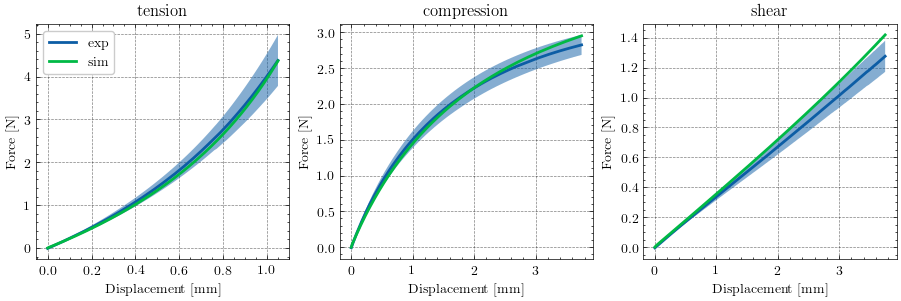

In [24]:
plot_force_displacement_fitting(
    exp_data=optimization.target_responses,
    sim_data=optimization.fitted_responses,
    figsize=(9, 3),
    lw=2.,
)